# ライブラリのインポート

In [1]:
import time
import warnings 
warnings.filterwarnings('ignore')

#Analysis 
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats

#Visulization
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
# color = sns.color_palette()
# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tls
# import plotly.figure_factory as ff

# data manipulation
import json
from pandas.io.json import json_normalize

# model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

import os

# メモリを効率的に使用するためのメソッド

In [2]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# データの読み込み

In [3]:
df_train = pd.read_csv("./train_V2.csv")
df_test = pd.read_csv("./test_V2.csv")

# データの相関

<AxesSubplot:>

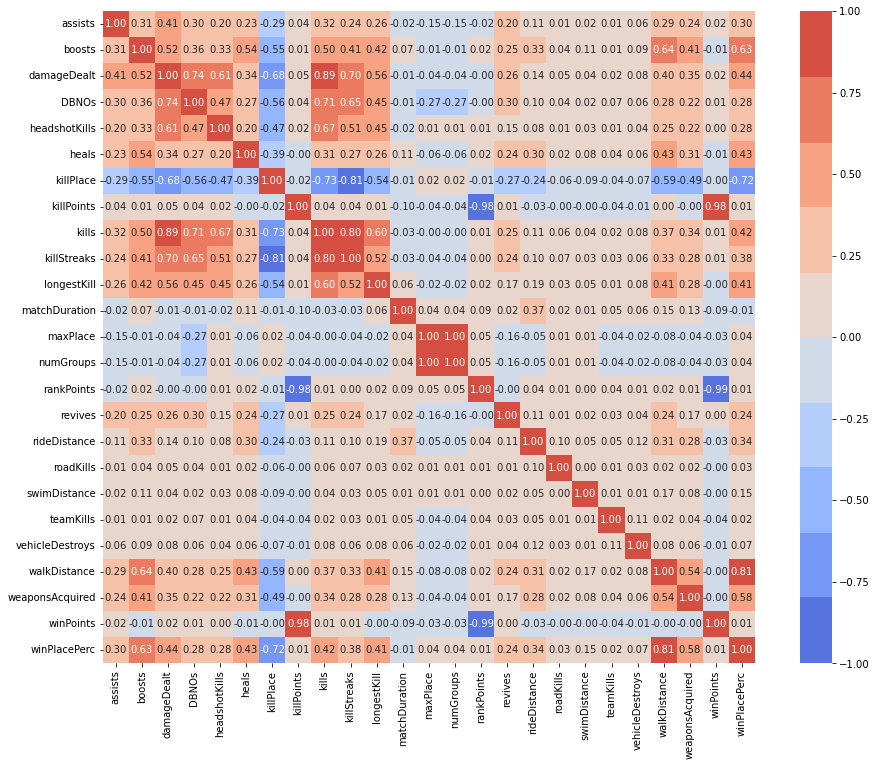

In [4]:
#変数間の相関係数を算出
corr = df_train.corr()

#相関係数のヒートマップを表示
fig, ax = plt.subplots(figsize=(16, 12)) 
sns.heatmap(corr, cmap= sns.color_palette('coolwarm', 10), annot=True, fmt='.2f', square=True, vmax=1, vmin=-1, center=0)

# 欠損値除去

In [5]:
# trainデータの欠損値の確認
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
winPlacePerc,1,0.000
matchType,0,0.000
winPoints,0,0.000
weaponsAcquired,0,0.000
walkDistance,0,0.000


In [6]:
# testデータの欠損値の確認
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
Id,0,0.000
groupId,0,0.000
weaponsAcquired,0,0.000
walkDistance,0,0.000
vehicleDestroys,0,0.000


In [7]:
df_train.dropna(axis=0, inplace=True)
df_train.isnull().sum() # 除去後

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

# 変数作成

In [8]:
# pandasの最大表示列数を広げておく（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

In [9]:
### 総距離 ###
def Total_Distance(df):
    df['total_Distance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']
    
    return df

In [10]:
### ヘッドショット率 ###
def Headshot_Rate(df):
    # ヘッドショット数 / キル数
    df['headshotrate'] = df['headshotKills'] / df['kills']
    
    # 欠損値を0で補完
    df['headshotrate'] = df['headshotrate'].fillna(0)
    
    return df

In [11]:
### チーター ###
def Hacker_Point(df):
    # ハッカーポイントの特徴量を作成
    df['hacker_pt'] = 0
    
    # ① 回復数=0 × キル数＞20
    df.loc[(df['heals'] < 1) & (df['kills'] > 20), 'hacker_pt'] += 1
    
    # ② 移動＜100ｍ × キル数＞20
    df.loc[(df['total_Distance'] < 100) & (df['kills'] > 20), 'hacker_pt'] += 1
    
    # ③ ヘッドショット数/キル数＞0.5 × キル数＞20
    df.loc[(df['headshotrate'] > 0.5) & (df['kills'] > 20), 'hacker_pt'] += 1
    
    #④ 最長距離長すぎる人→1000m以上
    df.loc[df['longestKill'] >= 1000, 'hacker_pt'] += 1
    
    return df

**チーターの人数**

In [12]:
#①の人数
#df_train[(df_train['heals'] < 1)  & (df_train['kills'] > 20)].describe()

In [13]:
#②の人数
#df_train[(df_train['total_Distance'] < 100) & (df_train['kills'] > 20)].describe()

In [14]:
#③の人数
#df_train[(df_train['headshotrate'] > 0.50) & (df_train['kills'] > 20)].describe()

In [15]:
#④の人数
#df_train[df_train['longestKill'] >= 1000].describe()

In [16]:
### 回線落ち ###
def Zombie(df):
    # zombie特徴量を作成
    df['zombie'] = 0
    
    # 移動0×武器0×キル0
    df.loc[(df['total_Distance'] < 1) & (df['weaponsAcquired'] < 1) & (df['kills'] < 1), 'zombie'] = 1
    
    return df

In [17]:
### マッチタイプ ###
def Match_Type(df):
    for i in ['fpp', 'tpp', 'solo', 'duo', 'squad']:
        if i == 'tpp':
            df[i] = 1
            df.loc[df['matchType'].str.contains('fpp'), i] = 0
            
        else:
            df[i] = 0
            df.loc[df['matchType'].str.contains(i), i] = 1
    
    return df

# プロット

In [18]:
# ハッカーポイントと目的変数
#df_train.plot(x='winPlacePerc',y='hacker_pt', kind='scatter', figsize = (8,6))

In [19]:
# ヘッドショット率と目的変数
#df_train.plot(x='winPlacePerc', y='headshotrate', kind='scatter', figsize=(8,6))

In [20]:
# キル数とヘッドショット率
#df_train.plot(x='headshotKills', y='kills', kind='scatter', figsize=(8,6))

In [21]:
# キル数と目的変数
#df_train.plot(x='winPlacePerc', y='kills', kind='scatter', figsize=(8,6))

In [22]:
# 最長射殺距離と目的変数
#df_train.plot(x='winPlacePerc',y='longestKill', kind='scatter', figsize = (8,6))

# 変数作成後データ

In [23]:
for df in [df_train, df_test]:
    Total_Distance(df)
    Headshot_Rate(df)
    Hacker_Point(df)
    Zombie(df)
    Match_Type(df)

# メモリ管理

In [24]:
import gc
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
gc.collect()

54

In [25]:
# メモリ食ってる変数を確認してみる
import sys
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 1000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                    KFold|      1064|
|             LabelEncoder|      1064|
|           StandardScaler|      1064|
|                     corr|      7242|
|                       df| 623249666|
|                  df_test| 623249666|
|                 df_train|1477609091|
|             missing_data|      2318|
|                  percent|      2094|
|                    total|      2094|


# データセット分割 (solo, duo, squad)
※LGBM_modelでデータ分割まで行っているため，人数確認用．

全体
- 訓練　：4446965人
- テスト：1934174人

solo
- 訓練　：720712人
- テスト：313924人

duo
- 訓練　：1315970人
- テスト：584286人

squad
- 訓練　：2400402人
- テスト：1032314人

その他
- 訓練　：9881人
- テスト：3650人

In [26]:
# soloのデータフレーム作成
df_train_solo = df_train[df_train['solo'] != 0]
df_test_solo = df_test[df_test['solo'] != 0]

# duoのデータフレーム作成
df_train_duo = df_train[df_train['duo'] != 0]
df_test_duo = df_test[df_test['duo'] != 0]

# squadのデータフレーム作成
df_train_squad = df_train[df_train['squad'] != 0]
df_test_squad = df_test[df_test['squad'] != 0]

In [27]:
# solo, duo, squad じゃない人(訓練データ)
df_train_other = df_train[(df_train['solo'] == 0) & (df_train['duo'] == 0) & (df_train['squad'] == 0)]

# solo, duo, squad じゃない人(テストデータ)
df_test_other = df_test[(df_test['solo'] == 0) & (df_test['duo'] == 0) & (df_test['squad'] == 0)]

# LightGBM

重要度：出てきた回数

重要度(gain)：貢献度

In [28]:
### 各マッチタイプ別にLGBMモデル構築 ###

def LGBM_model_matchtype(match_type):
    
    # 各マッチタイプ(solo, duo, squad, その他)で訓練・テストデータを作成
    if (match_type == 'solo') | (match_type == 'duo') | (match_type == 'squad'):
        df_train_matchtype = df_train[df_train[match_type] != 0]
        df_test_matchtype = df_test[df_test[match_type] != 0]
    
    # 説明変数の列名を抽出
    train_columns = list(df_test_matchtype.columns)

    # IDの抽出
    train_idx = df_train_matchtype.Id
    test_idx = df_test_matchtype.Id

    # 学習に使用しないカラムの削除
    train_columns.remove("Id")
    train_columns.remove("matchId")
    train_columns.remove("groupId")
    train_columns.remove("matchType")
    train_columns.remove("solo")
    train_columns.remove("duo")
    train_columns.remove("squad")
    
    # 説明変数 x と目的変数 y に分割
    x_train = df_train_matchtype[train_columns]
    x_test = df_test_matchtype[train_columns]
    y_train = df_train_matchtype["winPlacePerc"].astype('float')
    
    # 予測値を格納するデータフレームを作成
    oof_preds = np.zeros(x_train.shape[0]) # 検証データ用
    sub_preds = np.zeros(x_test.shape[0]) # テストデータ用
    
    # start = time.time()
    valid_score = 0
    
    # 訓練データを分割 (訓練:検証 = 8:2)
    trn_x, val_x, trn_y, val_y = train_test_split(x_train, y_train, train_size=0.2)
    
    # LGBM用のデータ加工
    train_data = lgb.Dataset(data=trn_x, label=trn_y)
    valid_data = lgb.Dataset(data=val_x, label=val_y)
    
    # パラメータ設定
    """
    params = {"objective" : "regression", 
              "metric" : "mae", 
              'n_estimators':10000, 
              'early_stopping_rounds':100,
              "num_leaves" : 30, 
              "learning_rate" : 0.3, 
              "bagging_fraction" : 0.9,
              "bagging_seed" : 0}
    """
    
    # optuna経由でLightGBMをインポート
    from optuna.integration import lightgbm as gbm
    
    # 固定するパラメータ
    params = {'objective': 'regression',
          'metric': 'rmse',
          'random_seed':0} 

    
    
    # モデル訓練
    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=1000)
    
    best_params = lgb_model.params
    print("Best params:", best_params)

    
    # 検証データの予測
    oof_preds = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
    oof_preds[oof_preds>1] = 1
    oof_preds[oof_preds<0] = 0
    
    # テストデータの予測
    sub_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration)
    sub_pred[sub_pred>1] = 1
    sub_pred[sub_pred<0] = 0
    
    # 予測精度
    print('Fold %2d RMSE : %.6f' % (1, mean_absolute_error(val_y, oof_preds)))
    valid_score += mean_absolute_error(val_y, oof_preds)
    
    # 出力用 DataFrame
    test_pred = pd.DataFrame({"Id": test_idx})
    test_pred["winPlacePerc"] = sub_pred
    
    importances = pd.DataFrame({'特徴':x_train.columns,
                                '重要度':lgb_model.feature_importance(),
                                '重要度（gain）':lgb_model.feature_importance(importance_type='gain').astype(int)})
    
    return test_pred, importances

In [29]:
### 全体でLGBMモデル構築 ###

def LGBM_model_all(test):
    
    # 説明変数の列名を抽出
    train_columns = list(test.columns)

    # IDの抽出
    train_idx = df_train.Id
    test_idx = test.Id

    # 学習に使用しないカラムの削除
    train_columns.remove("Id")
    train_columns.remove("matchId")
    train_columns.remove("groupId")
    train_columns.remove("matchType")
    train_columns.remove("solo")
    train_columns.remove("duo")
    train_columns.remove("squad")
    
    # 説明変数 x と目的変数 y に分割
    x_train = df_train[train_columns]
    x_test = test[train_columns]
    y_train = df_train["winPlacePerc"].astype('float')
    
    # 予測値を格納するデータフレームを作成
    oof_preds = np.zeros(x_train.shape[0]) # 検証データ用
    sub_preds = np.zeros(x_test.shape[0]) # テストデータ用
    
    # start = time.time()
    valid_score = 0
    
    # 訓練データを分割 (訓練:検証 = 8:2)
    trn_x, val_x, trn_y, val_y = train_test_split(x_train, y_train, train_size=0.8)
    
    # LGBM用のデータ加工
    train_data = lgb.Dataset(data=trn_x, label=trn_y)
    valid_data = lgb.Dataset(data=val_x, label=val_y)
    
    # パラメータ設定
    """
    params = {"objective" : "regression", 
              "metric" : "mae", 
              'n_estimators':10000, 
              'early_stopping_rounds':100,
              "num_leaves" : 30, 
              "learning_rate" : 0.3, 
              "bagging_fraction" : 0.9,
              "bagging_seed" : 0}
    """
    
    # optuna経由でLightGBMをインポート
    from optuna.integration import lightgbm as gbm
    
    # 固定するパラメータ
    params = {'objective': 'regression',
          'metric': 'rmse',
          'random_seed':0} 

    
    
    
    # モデル訓練
    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=1000)
    
    # 最適なパラメータの表示
    best_params = lgb_model.params
    print("Best params:", best_params)
    
    # 検証データの予測
    oof_preds = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
    oof_preds[oof_preds>1] = 1
    oof_preds[oof_preds<0] = 0
    
    # テストデータの予測
    sub_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration)
    sub_pred[sub_pred>1] = 1
    sub_pred[sub_pred<0] = 0
    
    # 予測精度
    print('Fold %2d RMSE : %.6f' % (1, mean_absolute_error(val_y, oof_preds)))
    valid_score += mean_absolute_error(val_y, oof_preds)
    
    # 出力用 DataFrame
    test_pred = pd.DataFrame({"Id": test_idx})
    test_pred["winPlacePerc"] = sub_pred
    
    importances = pd.DataFrame({'特徴':x_train.columns,
                                '重要度':lgb_model.feature_importance(),
                                '重要度（gain）':lgb_model.feature_importance(importance_type='gain').astype(int)})
    
    return test_pred, importances

In [30]:
df_solo = LGBM_model_matchtype('solo')
df_duo = LGBM_model_matchtype('duo')
df_squad = LGBM_model_matchtype('squad')

df_other = LGBM_model_all(df_test_other)
df_all = LGBM_model_all(df_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3094
[LightGBM] [Info] Number of data points in the train set: 144142, number of used features: 27
[LightGBM] [Info] Start training from score 0.485775
Best params: {'objective': 'regression', 'metric': 'rmse', 'random_seed': 0, 'num_iterations': 100, 'early_stopping_round': None}
Fold  1 RMSE : 0.042659
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2991
[LightGBM] [Info] Number of data points in the train set: 263194, number of used features: 29
[LightGBM] [Info] Start training from score 0.483906
Best params: {'objective': 'regression', 'metric': 'rmse', 'random_seed': 0, 'num_iteratio

In [31]:
# マッチタイプ別(solo, duo, squad, その他)の予測値
test_pred1 = pd.merge(df_solo[0], df_duo[0], how='outer')
test_pred2 = pd.merge(df_squad[0], df_other[0], how='outer')

test_pred = pd.merge(test_pred1, test_pred2, how='outer')
test_pred

,Id,winPlacePerc
0,37ae98f31ca542,0.625
1,6425cf14b2d488,0.357
2,494d3d9fad73b2,0.134
3,e59dd1435a2ecf,0.570
4,3e4413d4780f7c,0.152
...,...,...
1934169,356f2faa86c52a,0.000
1934170,907677c8142c16,0.813
1934171,de3cbf93f8c325,0.658
1934172,c6fa742f3fed71,0.300


solo

In [32]:
df_solo[1]

,特徴,重要度,重要度（gain）
0,assists,16,7
1,boosts,80,797
2,damageDealt,83,48
3,DBNOs,0,0
4,headshotKills,8,1
5,heals,26,21
6,killPlace,866,9611
7,killPoints,35,6
8,kills,237,484
9,killStreaks,36,20


In [33]:
df_solo[1].sort_values('重要度（gain）')

,特徴,重要度,重要度（gain）
27,zombie,2,0
26,hacker_pt,0,0
3,DBNOs,0,0
25,headshotrate,0,0
20,vehicleDestroys,0,0
17,roadKills,2,0
15,revives,0,0
4,headshotKills,8,1
29,tpp,1,5
19,teamKills,15,5


duo

In [34]:
df_duo[1]

,特徴,重要度,重要度（gain）
0,assists,31,133
1,boosts,74,1178
2,damageDealt,22,5
3,DBNOs,21,26
4,headshotKills,0,0
5,heals,45,109
6,killPlace,918,20472
7,killPoints,21,5
8,kills,286,1402
9,killStreaks,41,67


In [35]:
df_duo[1].sort_values('重要度（gain）')

,特徴,重要度,重要度（gain）
27,zombie,0,0
26,hacker_pt,0,0
25,headshotrate,3,0
4,headshotKills,0,0
20,vehicleDestroys,0,0
17,roadKills,0,0
19,teamKills,7,2
29,tpp,1,4
14,rankPoints,14,5
2,damageDealt,22,5


squad

In [36]:
df_squad[1]

,特徴,重要度,重要度（gain）
0,assists,50,438
1,boosts,44,1735
2,damageDealt,28,19
3,DBNOs,58,256
4,headshotKills,4,2
5,heals,37,133
6,killPlace,880,45908
7,killPoints,14,10
8,kills,299,4279
9,killStreaks,31,272


In [37]:
df_squad[1].sort_values('重要度（gain）')

,特徴,重要度,重要度（gain）
26,hacker_pt,0,0
20,vehicleDestroys,0,0
17,roadKills,0,0
4,headshotKills,4,2
27,zombie,6,3
25,headshotrate,8,4
18,swimDistance,12,9
7,killPoints,14,10
19,teamKills,14,13
2,damageDealt,28,19


other

In [38]:
df_other[1]

,特徴,重要度,重要度（gain）
0,assists,32,1706
1,boosts,50,17591
2,damageDealt,9,46
3,DBNOs,70,7524
4,headshotKills,0,0
5,heals,28,1204
6,killPlace,863,320979
7,killPoints,7,69
8,kills,270,22021
9,killStreaks,46,2605


In [39]:
df_other[1].sort_values('重要度（gain）')

,特徴,重要度,重要度（gain）
26,hacker_pt,0,0
4,headshotKills,0,0
25,headshotrate,0,0
20,vehicleDestroys,0,0
17,roadKills,3,32
2,damageDealt,9,46
18,swimDistance,10,62
7,killPoints,7,69
27,zombie,3,73
19,teamKills,10,90


all

In [40]:
df_other[1]

,特徴,重要度,重要度（gain）
0,assists,32,1706
1,boosts,50,17591
2,damageDealt,9,46
3,DBNOs,70,7524
4,headshotKills,0,0
5,heals,28,1204
6,killPlace,863,320979
7,killPoints,7,69
8,kills,270,22021
9,killStreaks,46,2605


In [41]:
df_other[1].sort_values('重要度（gain）')

,特徴,重要度,重要度（gain）
26,hacker_pt,0,0
4,headshotKills,0,0
25,headshotrate,0,0
20,vehicleDestroys,0,0
17,roadKills,3,32
2,damageDealt,9,46
18,swimDistance,10,62
7,killPoints,7,69
27,zombie,3,73
19,teamKills,10,90


In [42]:
#test_pred.to_csv("submission.csv" , index = False)
df_all[0].to_csv("submission.csv" , index = False)